# Predicting Diabetes Onset

### Introduction

This project embarks on the creation of a machine learning model designed to forecast the likelihood of diabetes in patients enlisted of a Diabetes Database. The dataset comprises diverse medical predictor variables. 

### Objective

Our primary objective revolves around leveraging these features to achieve an accurate prediction of diabetes onset.

### Analysis

1. Data Exploration: Delving into the dataset's intricacies, understanding its structure, and scrutinizing the distribution of variables.
2. Data Preprocessing: Rigorous cleaning procedures, addressing missing values, and meticulous data preparation for subsequent modeling stages.
3. Exploratory Data Analysis (EDA): Unveiling insights by visually depicting relationships between variables and extracting meaningful patterns.
4. Feature Selection: Discerning the most pertinent features crucial for our predictive task.
5. Model Selection and Training: Identifying and opting for the most suitable machine learning algorithms tailored to our classification objective and training and refining the chosen models to optimize performance.
6. Model Evaluation: Rigorous assessment of model efficacy using diverse evaluation metrics.
7. Conclusion: A succinct summation encapsulating our discoveries and an evaluation of the predictive model's effectiveness.

### Data Dictionary

| Feature                     | Description                                                |
|-----------------------------|------------------------------------------------------------|
| `pregnancies`               | Number of pregnancies.                                     |
| `glucose`                   | Plasma glucose concentration after a 2-hour oral glucose tolerance test. |
| `bloodPressure`             | Diastolic blood pressure (mm Hg) measured at 2 different time points. |
| `skinThickness`             | Triceps skinfold thickness (mm).                            |
| `insulin`                   | 2-hour serum insulin (mu U/ml).                            |
| `bmi`                       | Body mass index (weight in kg/(height in m)^2).            |
| `diabetesPedigreeFunction`  | A function that quantifies diabetes history in relatives.  |
| `Age`                       | Age in years.                                              |
| `outcome`                   | Target variable; 1 if the patient has diabetes, 0 otherwise.|
| `measurement_date`            | Dates of blood pressure measurement.                        |

#### Acknowledgements
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

## Let's get started our PRRRRRRRRRRREDICTION!

#### Importing required libraries

In [1]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
import os

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, classification_report
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

#### Load the dataset

In [2]:
# Load environment variables from the .env file (assuming it's present in the current directory)
load_dotenv()

# Retrieve the value of the "DB_STRING" environment variable from the loaded environment variables
DB_STRING = os.getenv("DB_STRING")

# Assuming "create_engine" is a function from a library like SQLAlchemy,
# this line creates a database engine using the database connection string obtained from the environment variable
db = create_engine(DB_STRING)

With the following SQL query, we join all relevant tables from the Diabetes Prediction database.

In [3]:
# Define a multi-line SQL query string
query_string = """
SET SCHEMA 'diabetes';  -- Set the database schema to 'diabetes'
SELECT
	p.*,  -- Select all columns from the 'patient' table
    bm.insulin,
    bm.glucose,
    bm.bloodpressure,
    bm.measurement_date,
    po.diabetespedigreefunction,
    po.outcome,
    s.skinthickness
FROM patient p
LEFT JOIN skin s
	ON p.id = s.patientid  -- Left join the 'skin' table on the 'id' column of 'patient' and 'patientid' column of 'skin'
LEFT JOIN blood_metrics bm
	ON p.id = bm.patientid  -- Left join the 'blood_metrics' table on the 'id' column of 'patient' and 'patientid' column of 'blood_metrics'
LEFT JOIN pedigree_outcome po
	ON p.id = po.patientid;  -- Left join the 'pedigree_outcome' table on the 'id' column of 'patient' and 'patientid' column of 'pedigree_outcome'
"""

# Use pandas to execute the SQL query and read the result into a DataFrame
df = pd.read_sql(query_string, db)


In [3]:
path = "/Users/stevenschepanski/Documents/Projects/Diabetes_Prediction/"

In [ ]:
# Create a CSV file from the DataFrame 'df'
df.to_csv(path + "data/diabetes.csv")
# The resulting CSV file will be saved in the "data" directory with the filename "diabetes.csv"

### 1. Data Exploration

In [4]:
# Read data from the CSV file "diabetes.csv" into a DataFrame 'df'
df = pd.read_csv(path + "data/diabetes.csv")

# Display the first few rows of the DataFrame using the 'head()' method
df.head()

,Unnamed: 0,id,Age,pregnancies,bmi,insulin,glucose,bloodpressure,measurement_date,diabetespedigreefunction,outcome,skinthickness
0,0,1,50,6,33.6,0,148,72,2022-12-13,1,1,35
1,1,2,31,1,26.6,0,85,66,2022-12-13,0,0,29
2,2,3,32,8,23.3,0,183,64,2022-12-13,1,1,0
3,3,4,21,1,28.1,94,89,66,2022-12-13,0,0,23
4,4,5,33,0,43.1,168,137,40,2022-12-13,2,1,35


In [5]:
# Check for duplicates in the DataFrame based on the 'id' column
duplicates = df[df.duplicated(subset=['id'], keep=False)]

# Display duplicate rows (if any)
if not duplicates.empty:
    print("Duplicate Rows Based on 'id':")
    print(duplicates.head(10))  # Print only the first 10 rows of duplicate entries
else:
    print("No Duplicate Rows Based on 'id'.")


Duplicate Rows Based on 'id':
   Unnamed: 0  id  Age  pregnancies   bmi  insulin  glucose  bloodpressure   
0           0   1   50            6  33.6        0      148             72  \
1           1   2   31            1  26.6        0       85             66   
2           2   3   32            8  23.3        0      183             64   
3           3   4   21            1  28.1       94       89             66   
4           4   5   33            0  43.1      168      137             40   
5           5   6   30            5  25.6        0      116             74   
6           6   7   26            3  31.0       88       78             50   
7           7   8   29           10  35.3        0      115              0   
8           8   9   53            2  30.5      543      197             70   
9           9  10   54            8   0.0        0      125             96   

  measurement_date  diabetespedigreefunction  outcome  skinthickness  
0       2022-12-13                      

In [6]:
# Sort the DataFrame 'df' by the 'id' column in ascending order
df.sort_values('id', inplace=True)

# Display the DataFrame after sorting
print("DataFrame After Sorting:")
df.head()


DataFrame After Sorting:


,Unnamed: 0,id,Age,pregnancies,bmi,insulin,glucose,bloodpressure,measurement_date,diabetespedigreefunction,outcome,skinthickness
0,0,1,50,6,33.6,0,148,72,2022-12-13,1,1,35
768,768,1,50,6,33.6,71,22,74,2022-12-01,1,1,35
769,769,2,31,1,26.6,9,62,60,2022-12-01,0,0,29
1,1,2,31,1,26.6,0,85,66,2022-12-13,0,0,29
770,770,3,32,8,23.3,65,125,66,2022-12-01,1,1,0


The dataframe contains duplicates based on `id`. This results from two different values in `bloodpressure` measured on two different dates (`measurement_date`). 

In [7]:
# Create new columns for the second blood pressure measurement and measurement date
# Create a new column 'bloodpressure_2' by shifting the 'bloodpressure' column for each 'id' group
df['bloodpressure_2'] = df.groupby('id')['bloodpressure'].shift(-1)

# Create a new column 'measurement_date_2' by shifting the 'measurement_date' column for each 'id' group
df['measurement_date_2'] = df.groupby('id')['measurement_date'].shift(-1)


In [8]:
# Drop rows with duplicate 'id' while keeping the first occurrence
# Create a new DataFrame 'df_resized' by dropping rows with duplicate 'id', keeping the first occurrence
df_resized = df.drop_duplicates(subset='id')


In [9]:
# Reset the index of the DataFrame 'df_resized' after dropping duplicates
# Reset the index of 'df_resized' and drop the existing index column
df_resized = df_resized.reset_index(drop=True)


In [10]:
# Display a concise summary of the DataFrame 'df_resized'
# The 'info' method provides a concise summary of the DataFrame, including data types, non-null counts, and memory usage
# The 'verbose=True' argument shows the full summary, including the counts of unique values in each column
df_resized.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                768 non-null    int64  
 1   id                        768 non-null    int64  
 2   Age                       768 non-null    int64  
 3   pregnancies               768 non-null    int64  
 4   bmi                       768 non-null    float64
 5   insulin                   768 non-null    int64  
 6   glucose                   768 non-null    int64  
 7   bloodpressure             768 non-null    int64  
 8   measurement_date          768 non-null    object 
 9   diabetespedigreefunction  768 non-null    int64  
 10  outcome                   768 non-null    int64  
 11  skinthickness             768 non-null    int64  
 12  bloodpressure_2           768 non-null    float64
 13  measurement_date_2        768 non-null    object 
dtypes: float64

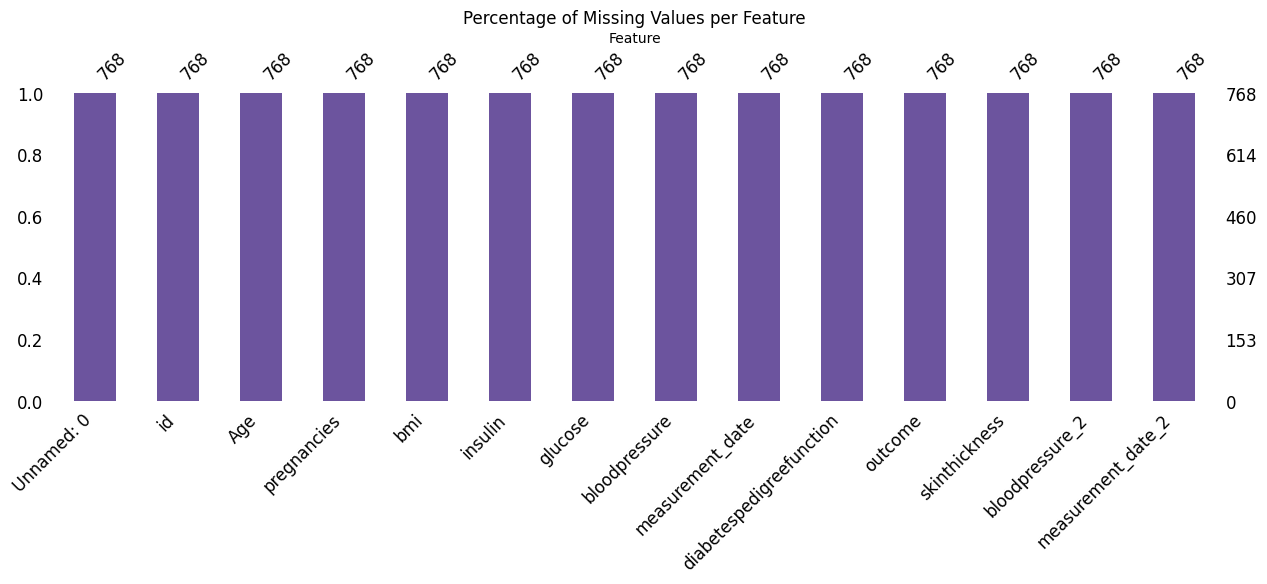

In [11]:
# custom colour
custom_colour = (108/255, 84/255, 158/255) # RGB(108, 84, 158)

# Visualize missing values using missingno
msno.bar(df_resized, figsize=(15, 4), color=custom_colour, fontsize=12, labels=True)

# Set plot labels and title
plt.title("Percentage of Missing Values per Feature")
plt.ylabel("Ratio of Missing Values per Feature")
plt.xlabel("Feature")

# Show the plot
plt.show()


There are no missing values in the data set which means we do not need to impute any data later on.

In [12]:
# Display descriptive statistics for numerical columns in the DataFrame 'df_resized'

# The 'describe' method provides summary statistics (mean, std, min, 25%, 50%, 75%, max) for numerical columns
# The 'drop' method is used to exclude specific columns ('Unnamed: 0', 'id') from the summary
# The 'T' at the end transposes the result for better readability
df_resized.describe().drop(columns=['Unnamed: 0', 'id']).T


,count,mean,std,min,25%,50%,75%,max
Age,768.0,33.240885,11.760232,21.0,24.00,29.0,41.0,81.0
pregnancies,768.0,3.845052,3.369578,0.0,1.00,3.0,6.0,17.0
bmi,768.0,31.992578,7.884160,0.0,27.30,32.0,36.6,67.1
insulin,768.0,63.729167,81.541358,0.0,0.00,48.0,86.0,744.0
glucose,768.0,112.165365,45.737332,0.0,84.75,112.0,145.0,199.0
bloodpressure,768.0,65.812500,28.506981,0.0,52.00,70.0,84.0,122.0
diabetespedigreefunction,768.0,0.373698,0.510322,0.0,0.00,0.0,1.0,2.0
outcome,768.0,0.348958,0.476951,0.0,0.00,0.0,1.0,1.0
skinthickness,768.0,20.536458,15.952218,0.0,0.00,23.0,32.0,99.0
bloodpressure_2,768.0,65.598958,27.917892,0.0,53.00,70.0,83.0,122.0


The dataframe has an equal count, meaning we eliminated the duplicates. Mean and std conspicuous. All features besides `age` have a min value of 0. For some `pregnancies`, `diabetespedigreefunction`, and `outcome`, this is logic. For the rest of the features, the min values need further investigations. The max values of the features `insulin`, `glucose`, `bloodpressure`, `skinthickness`, and `bloodpressure_2` need to be investigated and depending on their min values, we need to transform them properly.

In [13]:
# Obtain a list of column names in the DataFrame 'df_resized'

# The 'columns' attribute of a DataFrame returns an Index object containing column names
# The 'tolist()' method converts the Index object to a list
df_resized.columns.tolist()


['Unnamed: 0',
 'id',
 'Age',
 'pregnancies',
 'bmi',
 'insulin',
 'glucose',
 'bloodpressure',
 'measurement_date',
 'diabetespedigreefunction',
 'outcome',
 'skinthickness',
 'bloodpressure_2',
 'measurement_date_2']

### 2. Data Preprocessing

In [14]:
# Obtain the shape of the DataFrame 'df_resized'

# The 'shape' attribute of a DataFrame returns a tuple representing the number of rows and columns
df_resized.shape


(768, 14)

#### Handling of Features

The statistical summary of this dataset unveils noteworthy findings, particularly with certain variables such as `glucose`, `bloodpressure`, `skinthickness`, `insulin`, `bmi`, and `diabetespedigreefunction` displaying minimum values of zero. In the context a diabetes dataset, this discovery prompts concerns warranting further investigation.

Some plausible explanations exist for these zero values:

1. Missing Data: Zero values may signify missing data. Instances where measurments were not taken or recorded may default to zero.
2. Data Entry Errors: Human errors during data entry can introduce zero values erroneously, often arising from typographical mistakes or misinterpretations during data collection.
3. Medical Context: Some variables might legitimately record zero values under specific medical conditions. For instance, blood pressure readings of zero could result from instances where measurements are not actively taken.

To effectively address this issue and ensure the precision of our analysis, the subsequent steps encompass:

1. Data Exploration: A more in-depth exploration of the data to discern the scope and context of these zeros values.
2. Handling Missing Data: If zero values indicate missing data, employing suitable imputation techniques to fill in these gaps.
3. Data Cleaning: In cases where zero values stem from data entry erros, executing data cleaning procedures to rectify or validate entries.
4. Domain Experts: For variables with valid zero values, domain experts to in-depth acquision of this knowledge is necessary to comprehend the specific conditions under which these values are applicable.

Given the critical importance of data integrity, particularly in a medical dataset, the appropriate handling of zero values becomes paramount.


In [15]:
# Change the data type of date columns in the DataFrame 'df_resized'

# Convert the 'measurement_date' column to datetime data type
df_resized['measurement_date'] = df_resized['measurement_date'].astype('datetime64[ns]')

# Convert the 'measurement_date_2' column to datetime data type
df_resized['measurement_date_2'] = df_resized['measurement_date_2'].astype('datetime64[ns]')


In [16]:
# List of columns with zero values in the DataFrame 'df_resized'

# Create a list of column names representing numerical features that are expected to have zero values
zero_cols = ['bloodpressure', 'bmi', 'skinthickness', 'glucose', 'insulin']


In [17]:
# Check the count of zero values in specific features of the DataFrame 'df_resized'

# Print the number of zero values for each feature in the 'zero_cols' list
print("The number of zero values of the different features:")
for i in zero_cols:
    c = 0
    for x in (df_resized[i]):
        if x == 0:
            c = c + 1
    print(i, c)


The number of zero values of the different features:
bloodpressure 18
bmi 11
skinthickness 227
glucose 3
insulin 196


In [18]:
# Replace zero values with NaN in specific features of the DataFrame 'df_resized'

# Use the 'replace' method to replace zero values with NaN in the specified features
df_resized[zero_cols] = df_resized[zero_cols].replace(0, np.nan)


In [19]:
# Verify that zero values have been successfully replaced with NaN
print("Updated dataframe contains the following zero counts:")
for i in zero_cols:
    c = df_resized[i].isna().sum()  # Count NaN values after replacement
    print(i, c)


Updated dataframe contains the following zero counts:
bloodpressure 18
bmi 11
skinthickness 227
glucose 3
insulin 196


In [20]:
# Check for missing values (NaN) in the DataFrame 'df_resized' before imputation

# The 'isnull()' method creates a boolean mask indicating missing values, and 'sum()' calculates the sum of True values (missing values) for each column
missing_values_before_imputation = df_resized.isnull().sum()

# Print the count of missing values before imputation
print("Missing Values Before Imputation:\n", missing_values_before_imputation)


Missing Values Before Imputation:
 Unnamed: 0                    0
id                            0
Age                           0
pregnancies                   0
bmi                          11
insulin                     196
glucose                       3
bloodpressure                18
measurement_date              0
diabetespedigreefunction      0
outcome                       0
skinthickness               227
bloodpressure_2               0
measurement_date_2            0
dtype: int64


Now, the zero values were successfully replaced by `NaN`. The imputation of these entries will be performed in the pipline model later on.

### 3. Exploratory Data Analysis

In the Exploratory Data Analysis (EDA), my focus will be on examining the data distribution, investigating the correlation among features, and exploring the connection between the features and the target variable. I will commence by scrutinizing the data distribution, and subsequently, I will delve into the relationship between the target and the independent variables.

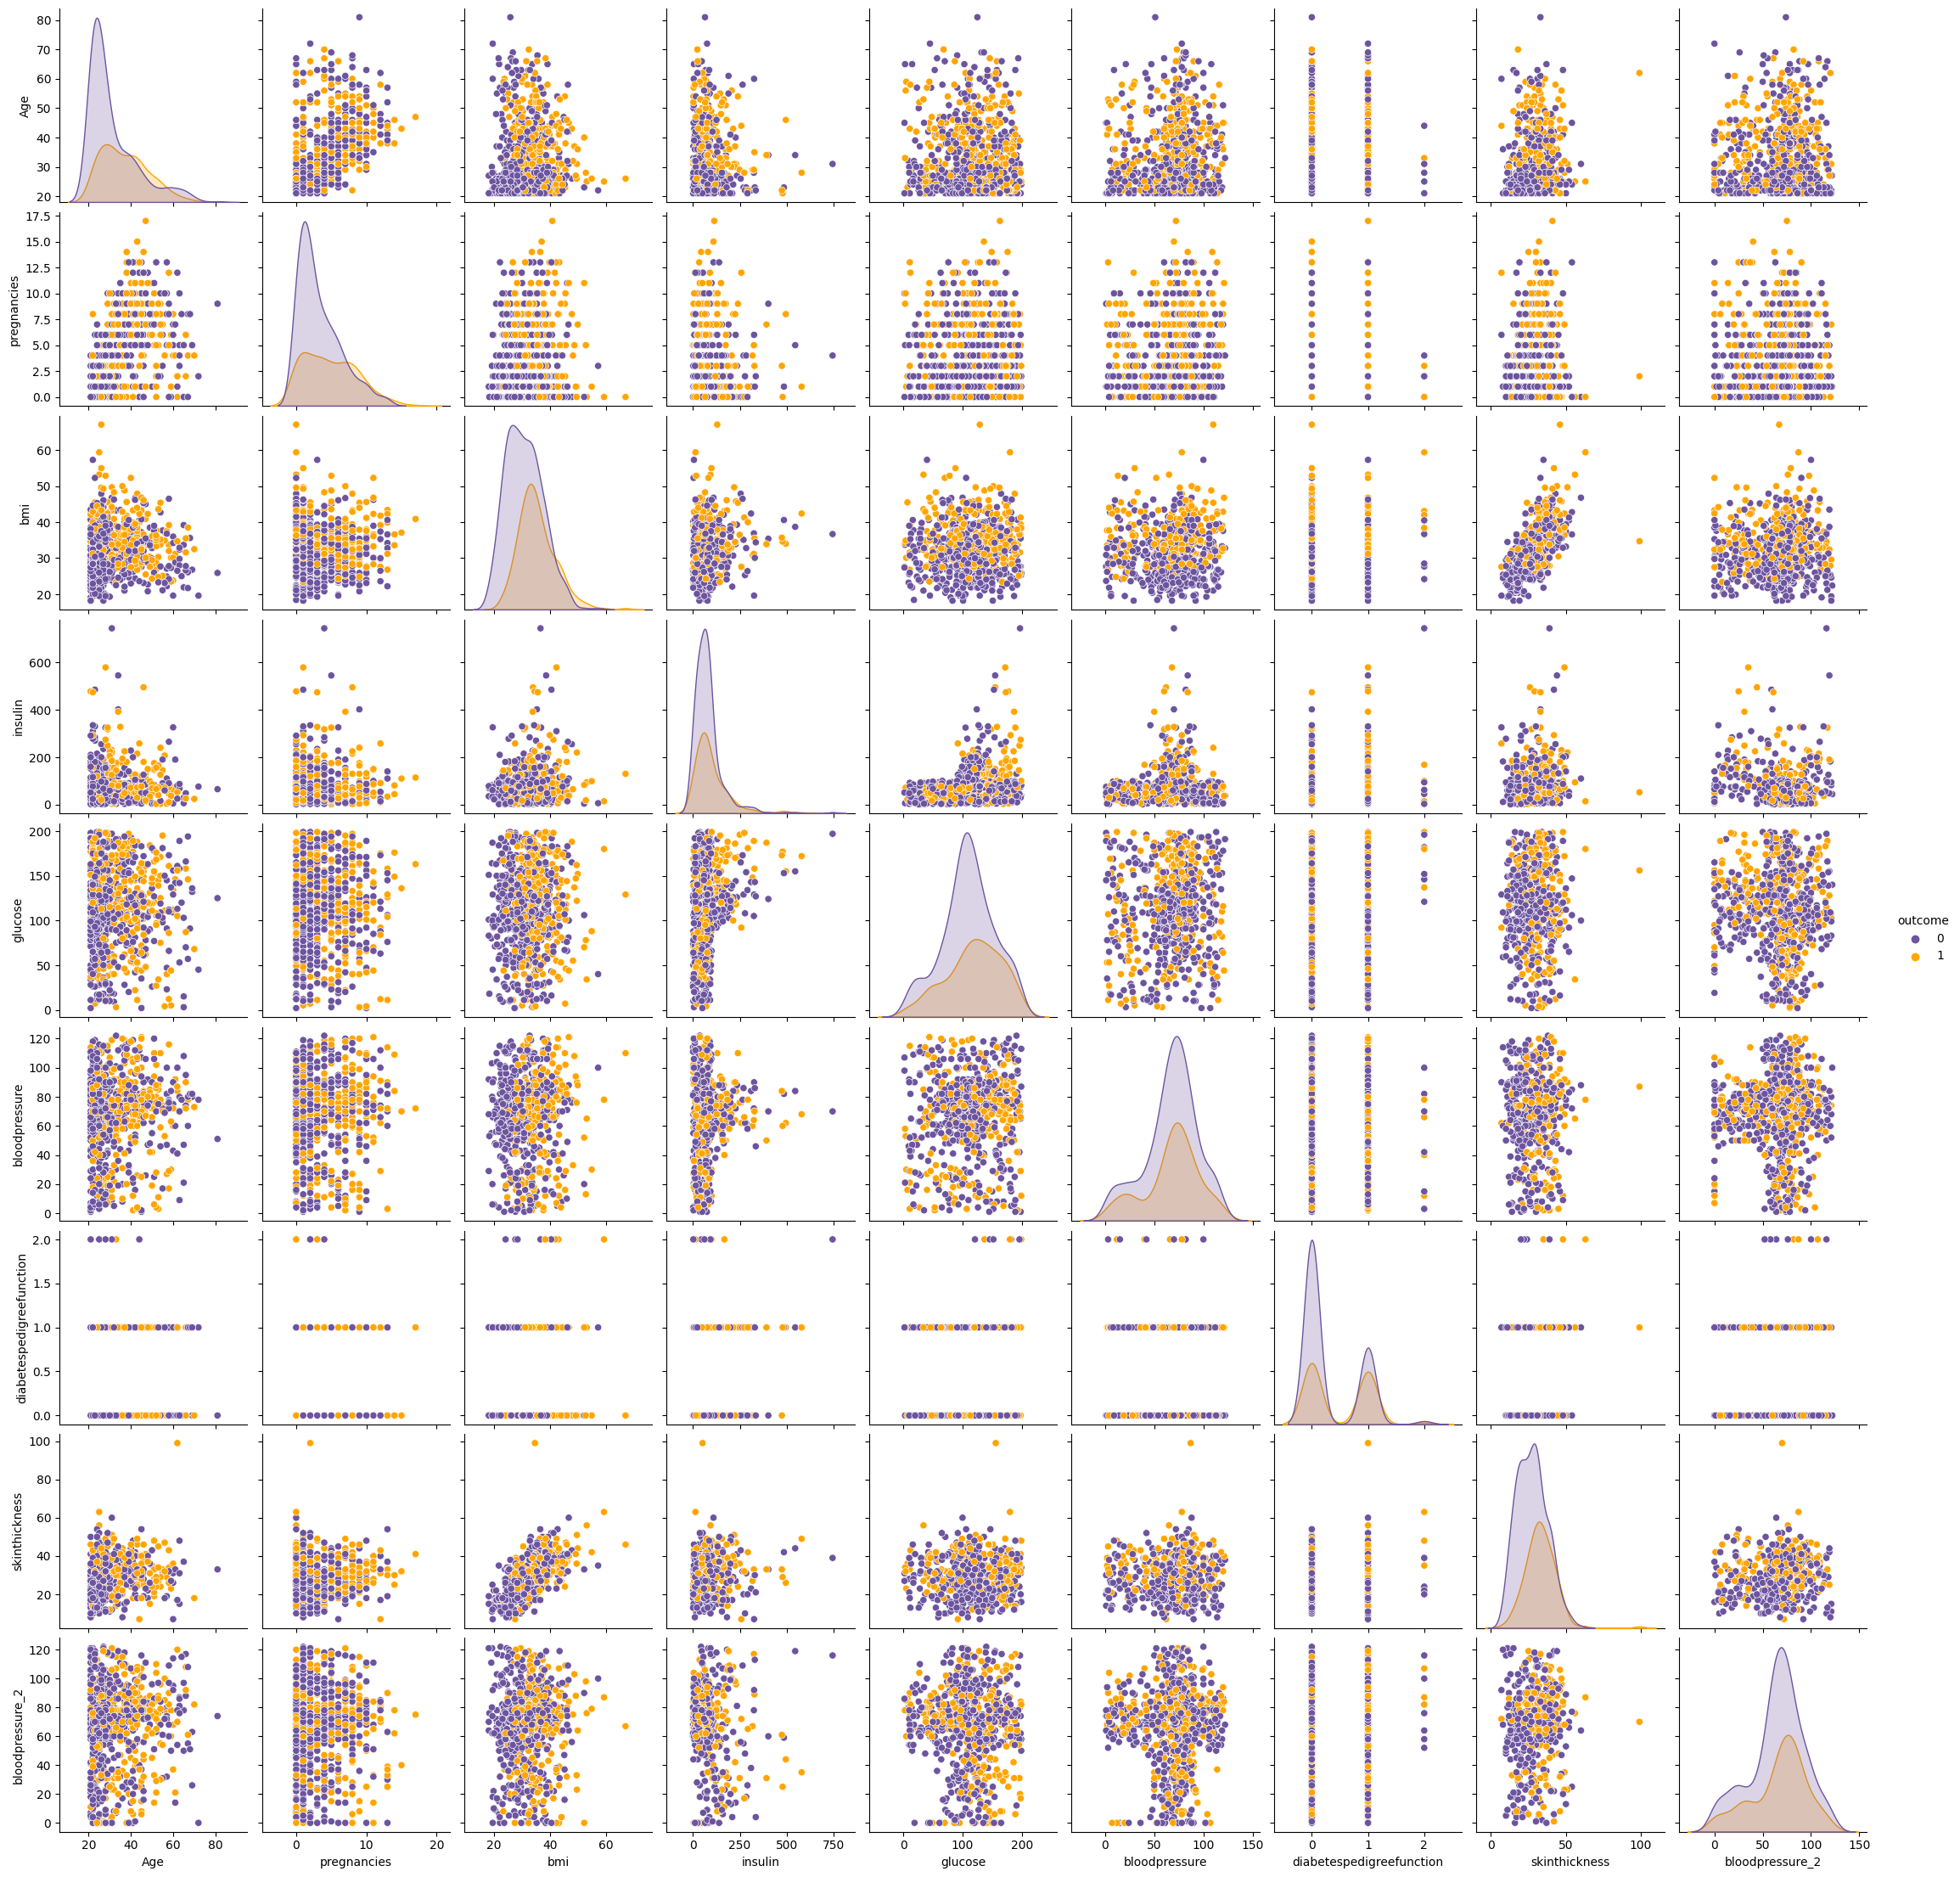

In [21]:
# Select specific columns from the DataFrame 'df_resized' for creating a pairplot

# Define a list of column names to be used in the pairplot
selected_columns = ['Age', 'pregnancies', 'bmi', 'insulin', 'glucose', 'bloodpressure', 'diabetespedigreefunction',
                    'skinthickness', 'bloodpressure_2', 'outcome']

# Create a pairplot using Seaborn
# The 'hue' parameter is set to 'outcome', which means the 'outcome' column will be used to color the data points
sns.pairplot(df_resized[selected_columns], hue='outcome', palette={0: custom_colour, 1: 'orange'})

# Show the pairplot
plt.show()

- The feature `skinthickness` shows an unusual value of approx. 100. This value stands alone and is part of the diabetes `outcome` class equal 1, meaning suffering from diabetes. This sample will be dropped entirely because it will be considered as an outlier and thus affect the performance of the predicitive model if it remains in the data frame.

- There is a positive correlation between `skinthickness` and `bmi`. This association is logic. However, high intercorrelation between features might affect the performance of the predictive model. Further investigations need to be done.

- There seems to be an association between `pregnancies` and `age` which is also logic. Further investigations need to be done.

- The histograms of both `bloodpressure` measurements assume still values that are very low. Further plotting is needed.

In [22]:
# Remove rows from the DataFrame 'df_resized' where 'skinthickness' is greater than 80

# The 'drop' method is used to remove rows based on a condition specified inside the square brackets
# The condition selects rows where the 'skinthickness' column is greater than 80
# The 'inplace=True' parameter means that the changes are applied directly to the DataFrame
df_resized.drop(df_resized[df_resized['skinthickness'] > 80].index, inplace=True)


In [23]:
# Print the first few rows of the DataFrame 'df_resized' to inspect the changes
print(df_resized.head())


   Unnamed: 0  id  Age  pregnancies   bmi  insulin  glucose  bloodpressure   
0           0   1   50            6  33.6      NaN    148.0           72.0  \
1         769   2   31            1  26.6      9.0     62.0           60.0   
2         770   3   32            8  23.3     65.0    125.0           66.0   
3           3   4   21            1  28.1     94.0     89.0           66.0   
4           4   5   33            0  43.1    168.0    137.0           40.0   

  measurement_date  diabetespedigreefunction  outcome  skinthickness   
0       2022-12-13                         1        1           35.0  \
1       2022-12-01                         0        0           29.0   
2       2022-12-01                         1        1            NaN   
3       2022-12-13                         0        0           23.0   
4       2022-12-13                         2        1           35.0   

   bloodpressure_2 measurement_date_2  
0             74.0         2022-12-01  
1             66.0

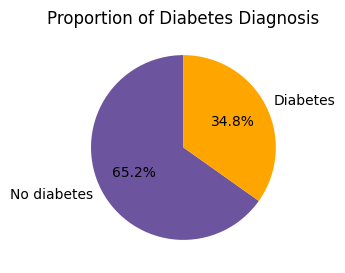

In [24]:
# Setting the figure size for the pie chart
plt.figure(figsize=(3, 3))

# Create a custom colour palette and labels
labels=['No diabetes', 'Diabetes']
colours = [custom_colour, 'orange']

# Creating a pie chart to visualize the proportion of 'outcome' values
# - df_resized['outcome'].value_counts(): Counts the occurrences of each unique value in the 'outcome' column.
# - labels=['No diabetes', 'Diabetes']: Specifies labels for the pie chart.
# - autopct='%1.1f%%': Displays the percentage on each wedge with one decimal place.
# - shadow=False: Disables shadow effect for the pie chart.
# - startangle=90: Rotates the start of the pie chart by 90 degrees.
plt.pie(df_resized['outcome'].value_counts(), labels=labels, autopct='%1.1f%%', colors=colours, shadow=False, startangle=90)

# Adding a title to the pie chart
plt.title('Proportion of Diabetes Diagnosis')

# Displaying the pie chart
plt.show()


It is great that there are less women suffering from diabetes per se, however this disproportion will affect our predictive model, hence the split of the data will be stratified based on the feature `outcome`.

#### Diabetes and all other variables

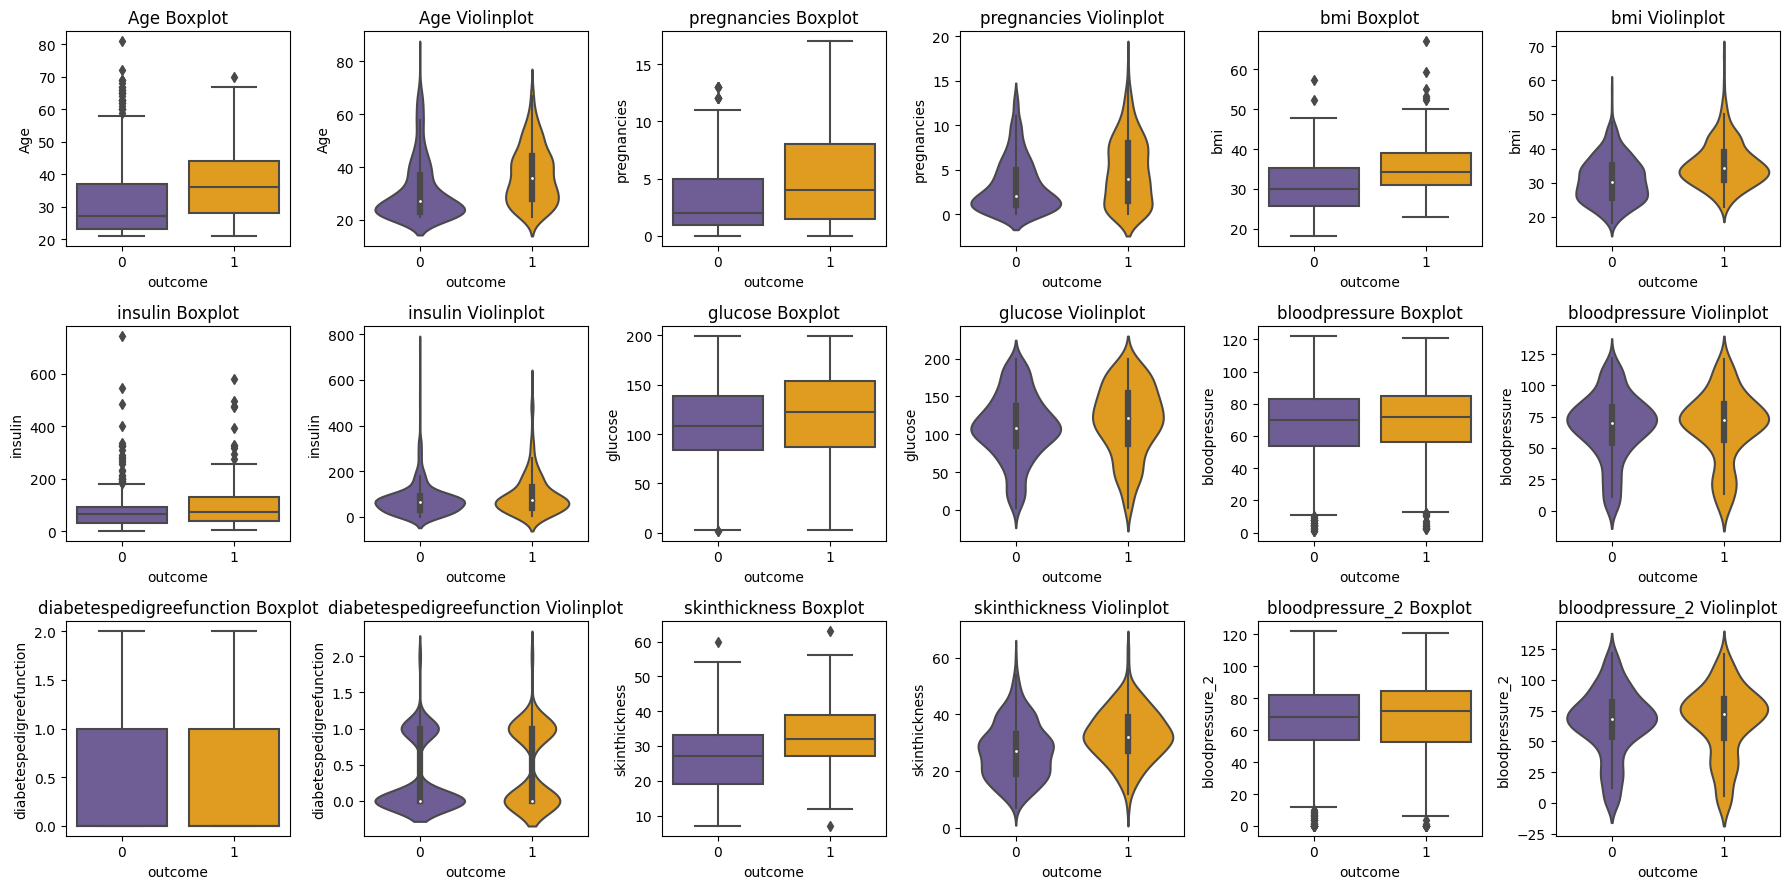

In [25]:
# List of variables to plot
variables = ['Age', 'pregnancies', 'bmi', 'insulin', 'glucose', 'bloodpressure', 'diabetespedigreefunction', 'skinthickness', 'bloodpressure_2']

# Create a 3x6 grid of subplots
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

# Iterate through the variables
for i, var in enumerate(variables):
    # Calculate the row and column indices for the current variable
    row, col = divmod(i, 3)

    # Boxplot: Plot boxplot in an even-numbered column
    sns.boxplot(x='outcome', y=var, data=df_resized, ax=axes[row, col*2], palette={0: custom_colour, 1: 'orange'})
    axes[row, col*2].set_title(f'{var} Boxplot')

    # Violinplot: Plot violinplot in the next odd-numbered column
    sns.violinplot(x='outcome', y=var, data=df_resized, ax=axes[row, col*2+1], palette={0: custom_colour, 1: 'orange'})
    axes[row, col*2+1].set_title(f'{var} Violinplot')

# Remove empty subplots if there are more than 9 variables
for i in range(len(variables)*2, 3 * 6):
    fig.delaxes(axes.flatten()[i])

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


- The `insulin` feature ranges from values around 0 until above 600 in the non-diabetic (`outcome`=0) group. In the diabetes group (`outcome`=1), the range is also somewhat high. This feature need to be scaled.
- The `skinthickness` feature looks better now.

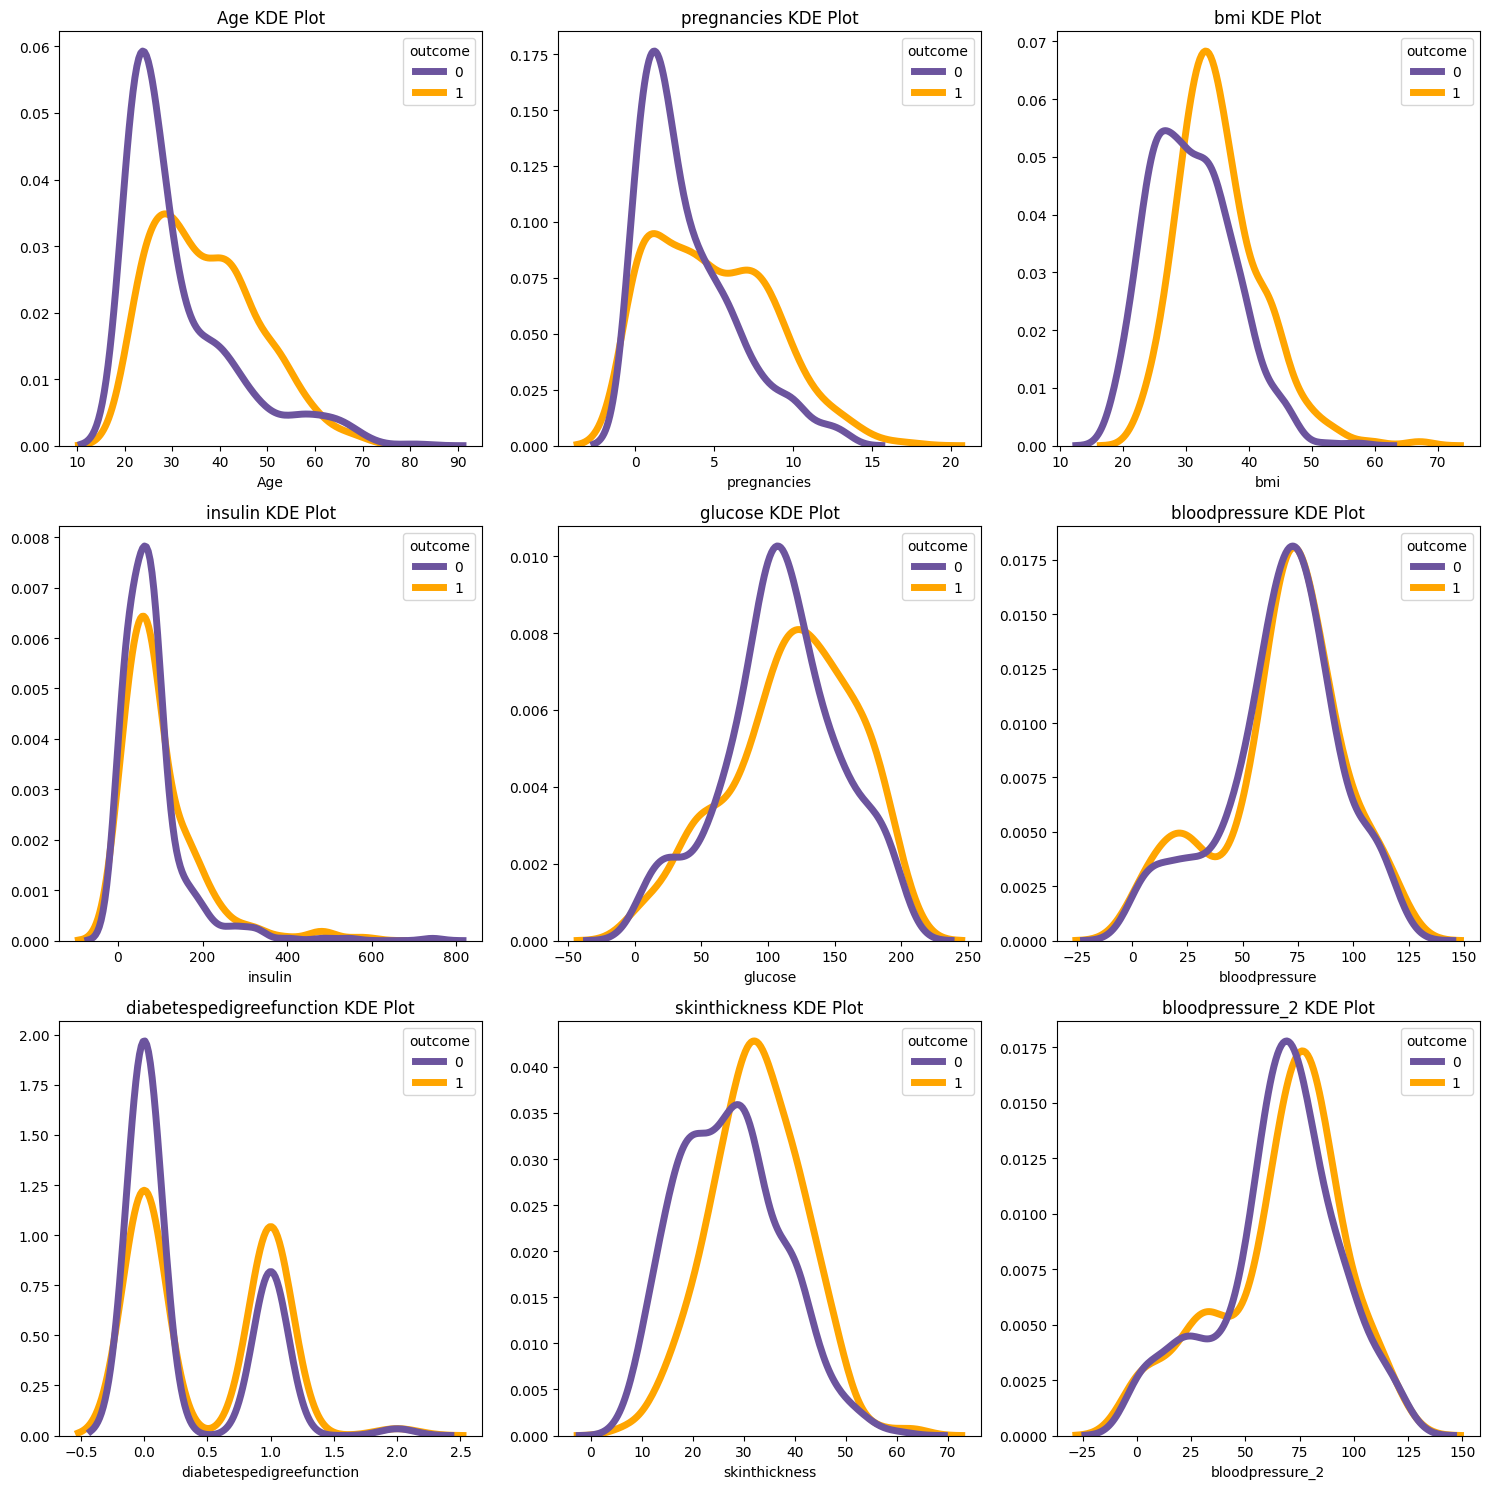

In [26]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Iterate through the variables
for i, var in enumerate(variables):
    # Calculate the row and column indices for the current variable
    row, col = divmod(i, 3)

    # KDE plot: Plot KDE plot in the current subplot
    sns.kdeplot(x=df_resized[var], hue=df_resized['outcome'], common_norm=False, ax=axes[row, col], palette={0: custom_colour, 1: 'orange'}, linewidth=5)
    axes[row, col].set_title(f'{var} KDE Plot')

    # Remove y-axis label for better appearance
    axes[row, col].set_ylabel('')

# Remove empty subplots if there are more than 9 variables
for i in range(len(variables), 3 * 3):
    fig.delaxes(axes.flatten()[i])

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


The KDE plots look good besides `bloodpressure_1` and `bloodpressure_2` because they assume zero values which literally would mean that the individual are dead.

In [27]:
# Count the number of values equal to 0 in 'bloodpressure' and 'bloodpressure_2'

# Count the number of values equal to 0 in 'bloodpressure'
count_bp1_zero = (df_resized['bloodpressure'] == 0).sum()

# Count the number of values equal to 0 in 'bloodpressure_2'
count_bp2_zero = (df_resized['bloodpressure_2'] == 0).sum()

# Print the results
print("Number of values equal to 0 in 'bloodpressure':", count_bp1_zero)
print("Number of values equal to 0 in 'bloodpressure_2':", count_bp2_zero)



Number of values equal to 0 in 'bloodpressure': 0
Number of values equal to 0 in 'bloodpressure_2': 20


The feature `bloodpressure_2` has 20 zero values which will be turned into `NaN` and later on imputed because a zero values does not seem logic. An assumption would be that the second measurement was missed and thus zero values were included.

In [28]:
# Replace zero values with NaN in the 'bloodpressure_2' column of the DataFrame 'df_resized'

# Use the 'replace' method to replace zero values with NaN in the 'bloodpressure_2' column
df_resized['bloodpressure_2'] = df_resized['bloodpressure_2'].replace(0, np.nan)


#### Correlation Matrix Heatmap

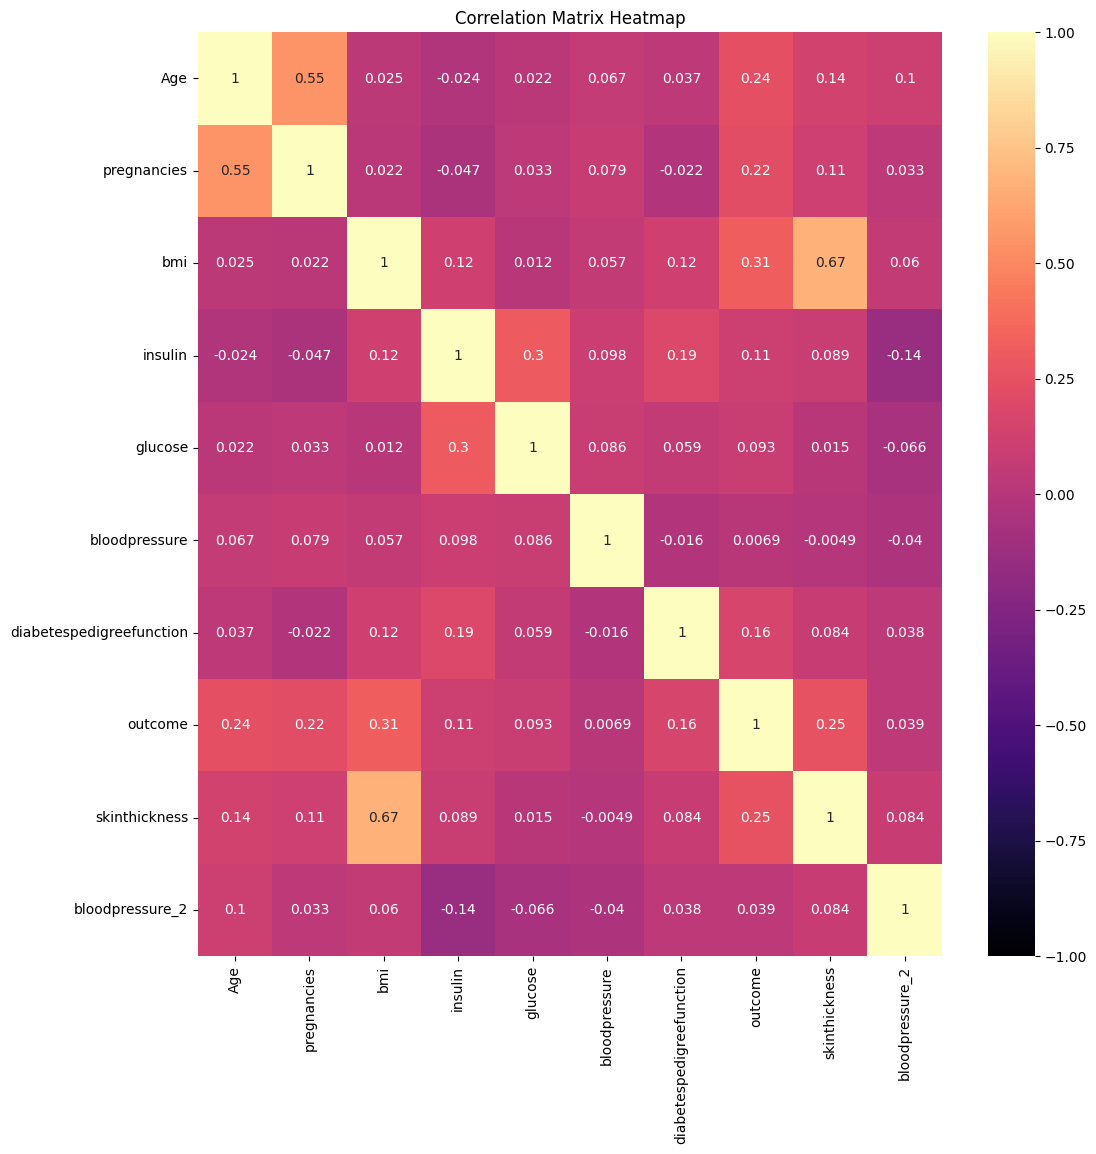

In [29]:
# List of variables to exclude from the correlation analysis
exclude_vars = ['Unnamed: 0', 'id', 'measurement_date', 'measurement_date_2']

# Create a new DataFrame excluding the specified variables
df_corr = df_resized.drop(columns=exclude_vars)

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Create a mask to hide values outside the range of interest
# mask = (correlation_matrix > 0.3) | (correlation_matrix < -0.3)

# Correlation matrix heatmap with a different color code and annotated values within the specified range
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='magma', vmax=1, vmin=-1).set_title('Correlation Matrix Heatmap')

# Show the plot
plt.show()


Correlation Matrix Summary

`Age` and Pregnancy-Related Variables
- `Age` shows a moderate positive correlation with `pregnancies` (r=0.54).
- A moderate positive correlation is observed between `pregnancies` and `age` (r=0.54).
- `bmi` has a negligible correlation with age (r=0.04).

`bmi` and Physiological Factors
- `bmi` exhibits a strong positive correlation with `skinthickness` (r=0.39).
- A positive correlation is noted between `bmi` and `diabetespedigreefunction` (r=0.11).

`insulin`, `glucose`, and `bloodpressure`
- `insulin` has a positive correlation with `glucose` (r=0.22) and a weak negative correlation with `bloodpressure` (r=-0.08).
- `glucose` and `bloodpressure` exhibit a weak positive correlation (r=0.08).

Diabetes `outcome`
- `outcome` (diabetes presence/absence) correlates positively with `Age` (r=0.24), `pregnancies` (r=0.22), and `bmi` (r=0.29).
- The correlation matrix supports the common sense understanding of diabetes prevalence in older individuals with more pregnancies and higher `bmi`.

`skinthickness` and `bloodpressure_2`
- `skinthickness` has a strong positive correlation with `bmi` (r=0.39) and a weak positive correlation with `diabetespedigreefunction` (r=0.15).
- `bloodpressure_2` shows negligible correlations with other variables.

This analysis provides insights into the relationships between key physiological variables, helping to understand patterns and potential factors influencing diabetes outcomes.


### 4. Feature Selection

Following the completion of an EDA and the examination of the correlation between features in our dataset, it has been ascertained that there is no correlation between features that does not make sense for the classification model. Consequently, the decision has been made to not undertake feature selection for this project.

Here are the reasons for this decision:

1. **Independence of Features:** The features in our dataset appear to be relatively independent of each other, and there is no strong linear correlation observed.
2. **Multicolinearity and Domain Knowledge:** It is a physiological correlation between 2 pairs of features that cannot be ignored in this data set, thus should intentionally be integrated into this classification.
3. **Low Dimensionality:** The dataset has a managable number of features, and the absence of high feature correlation reduces the risk of mutlicolinearity.
4. **Noisy Features:** Through EDA, it has been established that the features included in our dataset are relevant for the task of predicting diabetes, and there are no apparent noisy or irrelevant features.
5. **Model Considerations:** Given the nature of this project, where the primary task is predicting diabetes, the choice between logistic regression and da decision tree as our machine learning algorithm is pivotal. Considering the unique characteristics of our dataset-where features exhibit relative independence, the dimensionality is manageable, and there are no apparent noisy or irrelevant features--there is a deliberate decision not to extensively explore feature selection methods. Our focus is on leveraging the entirety of available features for training logistic regression and decision tree models. This approach aligns with the project's specific requirements and objectives, emphasizing robustness and inclusivity in our predictive modelling.

### 5. Model Selection and Training
| Task                      | Features                                   | Pipeline                                |
|---------------------------|-------------------------------------------|-----------------------------------------|
| Scaling                   | `insulin`                                 | MinMaxScaler                            |
| KNN Imputation            | `bmi`, `pregnancies`, `bloodpressure`, `bloodpressure_2`, `insulin`, `glucose`, `skinthickness`| KNNImputer  |
|                           |                                           |                                         |
| Column Transform          | `insulin`                                 | MinMaxScaler                            |
| Column Transform          | `bmi`, `pregnancies`, `bloodpressure`, `bloodpressure_2`, `insulin`, `glucose`, `skinthickness`| KNNImputer  |


### Split in training and test data

In [30]:
# Display the first few rows of the DataFrame 'df_resized'
df_resized.head()


,Unnamed: 0,id,Age,pregnancies,bmi,insulin,glucose,bloodpressure,measurement_date,diabetespedigreefunction,outcome,skinthickness,bloodpressure_2,measurement_date_2
0,0,1,50,6,33.6,NaN,148.0,72.0,2022-12-13,1,1,35.0,74.0,2022-12-01
1,769,2,31,1,26.6,9.0,62.0,60.0,2022-12-01,0,0,29.0,66.0,2022-12-13
2,770,3,32,8,23.3,65.0,125.0,66.0,2022-12-01,1,1,NaN,64.0,2022-12-13
3,3,4,21,1,28.1,94.0,89.0,66.0,2022-12-13,0,0,23.0,62.0,2022-12-01
4,4,5,33,0,43.1,168.0,137.0,40.0,2022-12-13,2,1,35.0,107.0,2022-12-01


In [31]:
# List of columns to impute
columns_to_impute = ['bmi', 'insulin', 'glucose', 'bloodpressure', 'skinthickness', 'bloodpressure_2']

# Extract features and target variable
X = df_resized.drop(columns=['Unnamed: 0', 'id', 'measurement_date', 'measurement_date_2'])

# Extract target variable
y = df_resized['outcome']

# Split the data into training and testing sets with stratification
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df_resized['outcome'])


### Dummy Model

In [32]:
# Create a DummyClassifier with a strategy of predicting the most frequent class
dummy_model = DummyClassifier(strategy='most_frequent')

# Fit the DummyClassifier on the feature matrix X and the target variable y
dummy_model.fit(X, y)

# Evaluate the performance of the DummyClassifier by calculating the accuracy on the training data
accuracy = dummy_model.score(X, y)

# Print the accuracy of the DummyClassifier
print("Accuracy of the DummyClassifier:", round(accuracy, 2))


Accuracy of the DummyClassifier: 0.65


The DummyClassifier with a 'most_frequent' strategy achieved an accuracy of 0.65, serving as a baseline for evaluating the performance of more advanced models.

### The Model

In [33]:
# Create pipelines for imputing and scaling 'insulin' and 'bmi' features

# Pipeline for 'insulin' feature
pipeline_insulin = Pipeline([
    ('impute', KNNImputer(n_neighbors=5)),  # Impute missing values using KNNImputer with 5 neighbors
    ('scale', MinMaxScaler())  # Scale values to the [0, 1] range using MinMaxScaler
])

# Pipeline for 'bmi' feature
pipeline_bmi = Pipeline([
    # ('bmi_scaler', StandardScaler()),  # Uncomment this line to use StandardScaler for scaling
    ('bmi_imputer', KNNImputer(n_neighbors=7)),  # Impute missing values using KNNImputer with 7 neighbors
    ('bmi_bin', KBinsDiscretizer(n_bins=5))  # Discretize continuous values into 5 bins using KBinsDiscretizer
])

# Pipeline for 'age' and 'pregnancy' features
pipeline_age_pregnancy = Pipeline([
    ('age_pregnancy_imputer', KNNImputer(n_neighbors=5)), # Impute missing values using KNNImputer with 5 neighbors
    ('age_pregnancy_bin', KBinsDiscretizer(n_bins=3))  # Discretize continuous values into 5 bins using KBinsDiscretizer
])


In [34]:
# Define a ColumnTransformer to apply different transformations to different subsets of features

column_transformer = ColumnTransformer([
    # Pipeline for 'bmi' feature
    ('bmi', pipeline_bmi, ['bmi']),

    # Pipeline for 'age' and 'pregnancy' features
    ('age_pregnancy', pipeline_age_pregnancy, ['Age', 'pregnancies']),
    
    # Impute missing values and scale specified features using KNNImputer and MinMaxScaler for 'insulin' feature
    ('impute_scale', pipeline_insulin, ['insulin']),
    
    # Perform one-hot encoding on the 'diabetespedigreefunction' feature
    ('pedigree', OneHotEncoder(drop='first'), ['diabetespedigreefunction']),
    
    # Impute and scale specified features using KNNImputer and MinMaxScaler for remaining features, including 'Age'
    ('impute_scale_remaining', Pipeline([
        ('impute', KNNImputer(n_neighbors=5)),
        ('scale', MinMaxScaler())
    ]), ['Age', 'glucose', 'bloodpressure', 'skinthickness', 'bloodpressure_2']),
], remainder='drop')
# The 'remainder' parameter specifies that any columns not explicitly transformed should be left unchanged.

# The column_transformer is now ready to be used in a pipeline or applied directly to the data.


In [35]:
# Define the pipelines for different models

# Logistic Regression with Polynomial Features
pipeline_logistic_regression = Pipeline([
    ('ct', column_transformer),  # Apply the ColumnTransformer defined earlier
    ('poly', PolynomialFeatures(degree=3)),  # Add polynomial features of degree 3
    ('model', LogisticRegression(penalty='l2'))  # Logistic Regression model with L2 regularization
])

# Decision Tree
pipeline_decision_tree = Pipeline([
    ('ct', column_transformer),  # Apply the ColumnTransformer defined earlier
    ('model', DecisionTreeClassifier(max_depth=5))  # Decision Tree Classifier with a maximum depth of 5
])

# Linear Regression
pipeline_linear_regression = Pipeline([
    ('ct', column_transformer),  # Apply the ColumnTransformer defined earlier
    ('model', LinearRegression())  # Linear Regression model
])


In [36]:
# Train and evaluate each pipeline

# Logistic Regression with Polynomial Features
pipeline_logistic_regression.fit(Xtrain, ytrain)
accuracy_logistic_regression = pipeline_logistic_regression.score(Xtest, ytest)
print('Logistic Regression with Polynomial Features:', round(accuracy_logistic_regression, 2))

# Decision Tree
pipeline_decision_tree.fit(Xtrain, ytrain)
accuracy_decision_tree = pipeline_decision_tree.score(Xtest, ytest)
print('Decision Tree:', round(accuracy_decision_tree, 2))

# Linear Regression
pipeline_linear_regression.fit(Xtrain, ytrain)
accuracy_linear_regression = pipeline_linear_regression.score(Xtest, ytest)
print('Linear Regression:', round(accuracy_linear_regression, 2))


Logistic Regression with Polynomial Features: 0.63
Decision Tree: 0.67
Linear Regression: 0.16


In [37]:
# Perform 10-fold cross-validation on the logistic regression model

# Xtrain and ytrain are the training data and labels
# cv=10 specifies 10-fold cross-validation
# n_jobs=-1 parallelizes the cross-validation process using all available CPU cores
cross_val_results = cross_val_score(pipeline_logistic_regression, Xtrain, ytrain, cv=10, n_jobs=1)


In [38]:
# Calculate the mean of the cross-validation results
mean_accuracy = cross_val_results.mean()

# Output the mean accuracy
print("Mean Accuracy:", round(mean_accuracy, 2))


Mean Accuracy: 0.68


### Hyperparameter search: Logistic regression

In [39]:
# Retrieve the current parameters of the logistic regression pipeline
pipeline_logistic_regression.get_params()


{'memory': None,
 'steps': [('ct', ColumnTransformer(transformers=[('bmi',
                                    Pipeline(steps=[('bmi_imputer',
                                                     KNNImputer(n_neighbors=7)),
                                                    ('bmi_bin',
                                                     KBinsDiscretizer())]),
                                    ['bmi']),
                                   ('age_pregnancy',
                                    Pipeline(steps=[('age_pregnancy_imputer',
                                                     KNNImputer()),
                                                    ('age_pregnancy_bin',
                                                     KBinsDiscretizer(n_bins=3))]),
                                    ['Age', 'pregnancies']),
                                   ('impute_scale',
                                    Pipeline(steps=[('impute', KNNImputer()),
                                          

In [56]:
# Define a dictionary of hyperparameter distributions for a randomized search

param_dist = {
    'ct__bmi__bmi_bin__n_bins': [5, 7, 9, 11, 13],  # Number of bins for 'bmi' discretization
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Adjust hyperparameters for logistic regression
    'ct__bmi__bmi_imputer': [KNNImputer(), SimpleImputer()],  # Imputer choices for 'bmi'
    'ct__impute_scale_remaining__scale': [MinMaxScaler(), StandardScaler()],  # Scaler choices for remaining features
    'ct__impute_scale__impute__n_neighbors': [5, 7, 9, 11, 13],  # Number of neighbors for imputation
    'poly__degree': [3, 5],  # Polynomial degrees for logistic regression with polynomial features
    'model__penalty': ['l1', 'l2'],  # Regularization penalty choices for logistic regression
}



In [57]:
# Set up a randomized search for hyperparameter tuning

# Create a RandomizedSearchCV object with the logistic regression pipeline, hyperparameter distributions,
# number of iterations, stratified k-fold cross-validation, and parallelization using 4 CPU cores
random_search_log_regression = RandomizedSearchCV(
    pipeline_logistic_regression, 
    param_distributions=param_dist,  # Hyperparameter distributions to sample from
    n_iter=10,  # Number of iterations (adjust as needed)
    cv=StratifiedKFold(n_splits=5),  # Use stratified k-fold cross-validation for classification
    n_jobs=3  # Parallelize the search using 4 CPU cores (-1 uses all available cores)
)

# Fit the model using the randomized search
random_search_log_regression.fit(Xtrain, ytrain)

# Output the best parameters found by the randomized search
print("Best Parameters:", random_search_log_regression.best_params_)


/Users/stevenschepanski/Documents/Projects/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/stevenschepanski/Documents/Projects/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Best Parameters: {'poly__degree': 5, 'model__penalty': 'l2', 'model__C': 0.001, 'ct__impute_scale_remaining__scale': StandardScaler(), 'ct__impute_scale__impute__n_neighbors': 11, 'ct__bmi__bmi_imputer': SimpleImputer(), 'ct__bmi__bmi_bin__n_bins': 13}


In [58]:
# Save the best model
joblib.dump(random_search_log_regression, path + "models/random_search_log_regression.joblib")

['/Users/stevenschepanski/Documents/Projects/Diabetes_Prediction/models/random_search_log_regression.joblib']

### Hyperparameter search: Decision Tree

In [59]:
# Retrieve the current parameters of the decision tree pipeline
pipeline_decision_tree.get_params()


{'memory': None,
 'steps': [('ct', ColumnTransformer(transformers=[('bmi',
                                    Pipeline(steps=[('bmi_imputer',
                                                     KNNImputer(n_neighbors=7)),
                                                    ('bmi_bin',
                                                     KBinsDiscretizer())]),
                                    ['bmi']),
                                   ('age_pregnancy',
                                    Pipeline(steps=[('age_pregnancy_imputer',
                                                     KNNImputer()),
                                                    ('age_pregnancy_bin',
                                                     KBinsDiscretizer(n_bins=3))]),
                                    ['Age', 'pregnancies']),
                                   ('impute_scale',
                                    Pipeline(steps=[('impute', KNNImputer()),
                                          

In [60]:
# Define a parameter grid for hyperparameter tuning of the Decision Tree model

param_dist_decision_tree = {
    'ct__bmi__bmi_imputer__n_neighbors': [3, 5, 7, 9],  # Number of neighbors for imputing 'bmi'
    'ct__bmi__bmi_bin__n_bins': [3, 5, 7, 9],  # Number of bins for 'bmi' discretization
    'ct__impute_scale__impute__n_neighbors': [3, 5, 7, 9],  # Number of neighbors for imputing other features
    'model__criterion': ['gini', 'entropy'],  # Split criterion for the Decision Tree
    'model__max_depth': [None, 5, 10, 15, 20, 25],  # Maximum depth of the Decision Tree
    'model__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'model__min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
    'model__min_impurity_decrease': [0.0, 0.01, 0.1, 0.2],  # Minimum impurity decrease to split a node
}



In [61]:
# Set up a randomized search for hyperparameter tuning of the Decision Tree model

# Create a RandomizedSearchCV object with the decision tree pipeline, hyperparameter distributions,
# number of iterations, stratified k-fold cross-validation, and parallelization using 4 CPU cores
random_search_decision_tree = RandomizedSearchCV(
    pipeline_decision_tree, 
    param_distributions=param_dist_decision_tree,  # Hyperparameter distributions to sample from
    n_iter=10,  # Number of iterations (adjust as needed)
    cv=StratifiedKFold(n_splits=5),  # Use stratified k-fold cross-validation for classification
    n_jobs=3  # Parallelize the search using 4 CPU cores (-1 uses all available cores)
)

# Fit the model using the randomized search
random_search_decision_tree.fit(Xtrain, ytrain)

# Output the best hyperparameters found by the randomized search for the Decision Tree model
print("Best Parameters for Decision Tree:", random_search_decision_tree.best_params_)


Best Parameters for Decision Tree: {'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__min_impurity_decrease': 0.0, 'model__max_depth': 5, 'model__criterion': 'entropy', 'ct__impute_scale__impute__n_neighbors': 7, 'ct__bmi__bmi_imputer__n_neighbors': 5, 'ct__bmi__bmi_bin__n_bins': 9}


In [62]:
# Save the best model
joblib.dump(random_search_decision_tree, path + "models/random_search_decision_tree.joblib")

['/Users/stevenschepanski/Documents/Projects/Diabetes_Prediction/models/random_search_decision_tree.joblib']

### 6. Model Evaluation

**Logistic Regression**

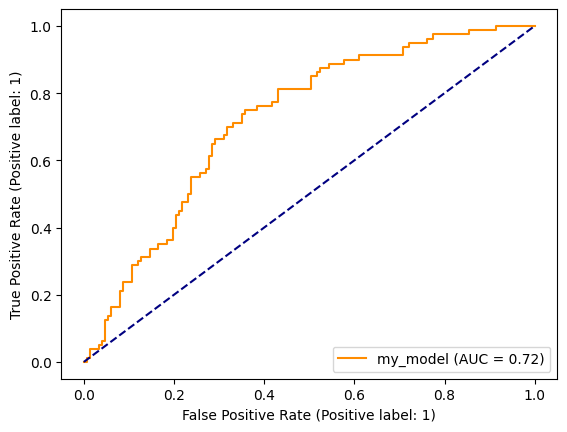

In [63]:
# Plot the ROC curve for model evaluation

# RocCurveDisplay.from_predictions: This function generates an ROC curve from true class labels (ytest) and predicted probabilities.
# ytest: True class labels for the test set.
# random_search.best_estimator_.predict_proba(Xtest)[:, 1]: Predicted probabilities of the positive class from the best estimator of the model.
# color="darkorange": Set the color of the ROC curve to dark orange.
# name='my_model': Assign a name to the model for display in the legend.

RocCurveDisplay.from_predictions(
    ytest, 
    random_search_log_regression.best_estimator_.predict_proba(Xtest)[:, 1],  # Probabilities of the positive class
    color="darkorange",  # Color for the ROC curve
    name='my_model'  # Name for the model in the legend
)

# plt.plot([0, 1], [0, 1], color='navy', linestyle='--'): Plot the diagonal line (y=x) on the ROC plot.
# This line represents a random classifier with no predictive power.

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')


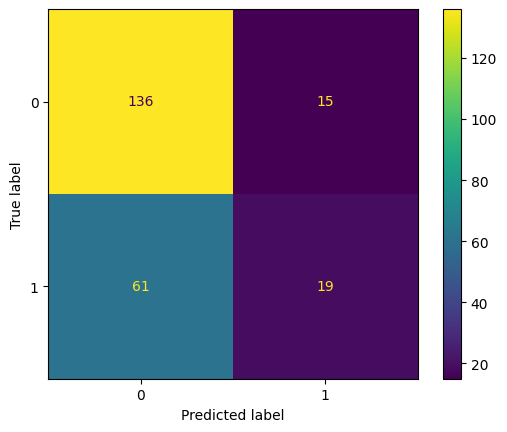

In [64]:
# Generate and plot the confusion matrix for model evaluation

# confusion_matrix: This function computes the confusion matrix to evaluate the classification performance.
# ytest: True class labels for the test set.
# random_search.best_estimator_.predict(Xtest): Predicted class labels from the best estimator of the model.

conf_matrix = confusion_matrix(ytest, random_search_log_regression.best_estimator_.predict(Xtest))

# ConfusionMatrixDisplay: This class creates a visual representation of the confusion matrix.
# conf_matrix: Confusion matrix to be displayed.

ConfusionMatrixDisplay(conf_matrix).plot()


In [65]:
# Print the classification report and accuracy score for model evaluation

# classification_report: This function generates a comprehensive classification report, including precision, recall, F1-score, and support.
# ytest: True class labels for the test set.
# random_search.best_estimator_.predict(Xtest): Predicted class labels from the best estimator of the model.

print(classification_report(ytest, random_search_log_regression.best_estimator_.predict(Xtest)))

# random_search.best_estimator_.score(Xtest, ytest): This method calculates and prints the accuracy score of the model on the test set.
# Xtest: Feature matrix of the test set.
# ytest: True class labels for the test set.

print(random_search_log_regression.best_estimator_.score(Xtest, ytest))


              precision    recall  f1-score   support

           0       0.69      0.90      0.78       151
           1       0.56      0.24      0.33        80

    accuracy                           0.67       231
   macro avg       0.62      0.57      0.56       231
weighted avg       0.64      0.67      0.63       231

0.670995670995671


In [66]:
# Perform cross-validation using the best estimator from the randomized search

# cross_val_score: This function performs cross-validation and returns an array of scores.
# random_search.best_estimator_: The best estimator (model) found by the randomized search.
# Xtrain: Feature matrix of the training set.
# ytrain: True class labels for the training set.
# cv=5: Number of cross-validation folds (in this case, 5-fold cross-validation).
# n_jobs=-1: Parallelizes the cross-validation process using all available CPU cores.

cross_val_results = cross_val_score(random_search_log_regression.best_estimator_, Xtrain, ytrain, cv=10, n_jobs=1)

# .mean(): Calculate the mean of the cross-validation results.

mean_accuracy = cross_val_results.mean()

# Output the mean accuracy from cross-validation.

print("Mean Accuracy:", round(mean_accuracy, 2))


Mean Accuracy: 0.66


Logistic Regression Performance Summary

The logistic regression model shows mixed performance in predicting diabetes:

- **Precision:** The model is 69% precise in identifying non-diabetic cases (0) and 57% precise in identifying diabetic cases (1). This indicates that when the model predicts a class, it is correct around 69% and 57% of the time for non-diabetic and diabetic cases, respectively.

- **Recall (Sensitivity):** The model exhibits high recall for non-diabetic cases (0) at 90%, suggesting it effectively captures true non-diabetic instances. However, the recall for diabetic cases (1) is lower at 25%, indicating a challenge in identifying true positive diabetic instances.

- **F1-Score:** The F1-score, a balance between precision and recall, is 0.78 for non-diabetic cases (0) and 0.35 for diabetic cases (1). The lower F1-score for diabetic cases reflects the trade-off between precision and recall in the model.

- **Accuracy:** The overall accuracy is 68%, indicating the proportion of correctly classified instances out of the total.

In summary, while the model demonstrates good precision for non-diabetic cases, there is room for improvement in correctly identifying diabetic cases, as reflected in lower recall and F1-score for the positive class.


**Decision Tree**

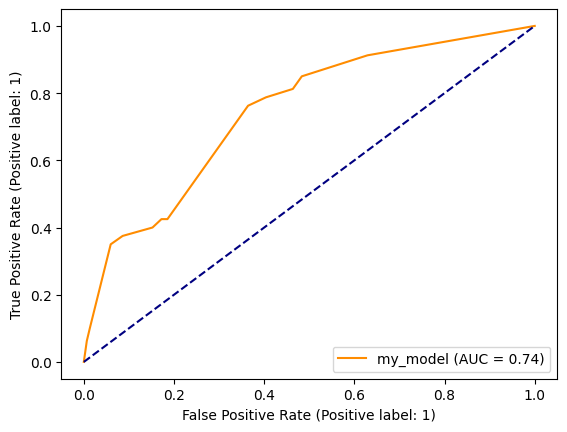

In [67]:
# Plot the ROC curve for the Decision Tree model's evaluation

# RocCurveDisplay.from_predictions: This function generates an ROC curve from true class labels (ytest) and predicted probabilities.
# ytest: True class labels for the test set.
# random_search_decision_tree.best_estimator_.predict_proba(Xtest)[:, 1]: Predicted probabilities of the positive class
#   from the best estimator of the Decision Tree model.
# color="darkorange": Set the color of the ROC curve to dark orange.
# name='my_model': Assign a name to the model for display in the legend.

RocCurveDisplay.from_predictions(
    ytest, 
    random_search_decision_tree.best_estimator_.predict_proba(Xtest)[:, 1],  # Probabilities of the positive class
    color="darkorange",  # Color for the ROC curve
    name='my_model'  # Name for the model in the legend
)

# plt.plot([0, 1], [0, 1], color='navy', linestyle='--'): Plot the diagonal line (y=x) on the ROC plot.
# This line represents a random classifier with no predictive power.

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')


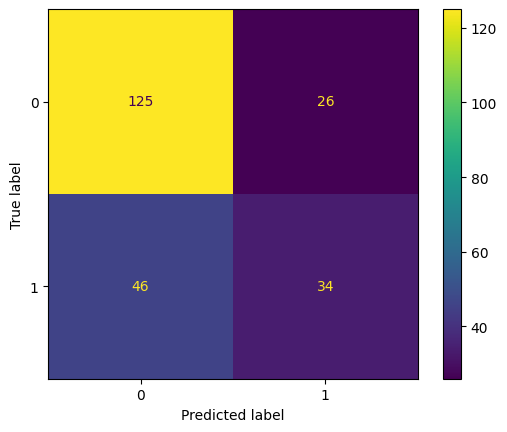

In [68]:
# Generate and plot the confusion matrix for the Decision Tree model's evaluation

# confusion_matrix: This function computes the confusion matrix to evaluate the classification performance.
# ytest: True class labels for the test set.
# random_search_decision_tree.best_estimator_.predict(Xtest): Predicted class labels from the best estimator
#   of the Decision Tree model.

conf_matrix_decision_tree = confusion_matrix(ytest, random_search_decision_tree.best_estimator_.predict(Xtest))

# ConfusionMatrixDisplay: This class creates a visual representation of the confusion matrix.
# conf_matrix_decision_tree: Confusion matrix to be displayed for the Decision Tree model.

ConfusionMatrixDisplay(conf_matrix_decision_tree).plot()


In [69]:
# Print the classification report and accuracy score for the Decision Tree model's evaluation

# classification_report: This function generates a comprehensive classification report, including precision, recall, F1-score, and support.
# ytest: True class labels for the test set.
# random_search_decision_tree.best_estimator_.predict(Xtest): Predicted class labels from the best estimator
#   of the Decision Tree model.

print(classification_report(ytest, random_search_decision_tree.best_estimator_.predict(Xtest)))

# random_search_decision_tree.best_estimator_.score(Xtest, ytest): This method calculates and prints the accuracy score
#   of the Decision Tree model on the test set.
# Xtest: Feature matrix of the test set.
# ytest: True class labels for the test set.

print(random_search_decision_tree.best_estimator_.score(Xtest, ytest))


              precision    recall  f1-score   support

           0       0.73      0.83      0.78       151
           1       0.57      0.42      0.49        80

    accuracy                           0.69       231
   macro avg       0.65      0.63      0.63       231
weighted avg       0.67      0.69      0.68       231

0.6883116883116883


In [70]:
# Perform cross-validation using the best estimator from the randomized search for the Decision Tree model

# cross_val_score: This function performs cross-validation and returns an array of scores.
# random_search_decision_tree.best_estimator_: The best estimator (model) found by the randomized search for the Decision Tree.
# Xtrain: Feature matrix of the training set.
# ytrain: True class labels for the training set.
# cv=5: Number of cross-validation folds (in this case, 5-fold cross-validation).
# n_jobs=-1: Parallelizes the cross-validation process using all available CPU cores for faster computation.

cross_val_results_decision_tree = cross_val_score(random_search_decision_tree.best_estimator_, Xtrain, ytrain, cv=10, n_jobs=2)

# .mean(): Calculate the mean of the cross-validation results.

mean_accuracy_decision_tree = cross_val_results_decision_tree.mean()

# Output the mean accuracy from cross-validation for the Decision Tree model.

print("Mean Accuracy (Decision Tree):", round(mean_accuracy_decision_tree, 2))


Mean Accuracy (Decision Tree): 0.68


Decision Tree Performance Summary

The decision tree model exhibits the following performance metrics:

- **Precision:** The model achieves 78% precision in identifying non-diabetic cases (0) and 56% precision in identifying diabetic cases (1). This indicates that when the model predicts a class, it is correct around 78% and 56% of the time for non-diabetic and diabetic cases, respectively.

- **Recall (Sensitivity):** The model shows 75% recall for non-diabetic cases (0) and 60% recall for diabetic cases (1). This suggests that the decision tree effectively captures true non-diabetic instances but has a moderate ability to identify true positive diabetic instances.

- **F1-Score:** The F1-score, a balance between precision and recall, is 0.76 for non-diabetic cases (0) and 0.58 for diabetic cases (1). The F1-scores indicate a reasonable balance between precision and recall for both classes.

- **Accuracy:** The overall accuracy is 70%, indicating the proportion of correctly classified instances out of the total.

- **Mean Accuracy (Decision Tree):** The mean accuracy across all predictions is 67%.

In summary, the decision tree model demonstrates good precision and recall for non-diabetic cases, while showing moderate performance for diabetic cases. The balanced F1-scores suggest a reasonable trade-off between precision and recall for both classes.


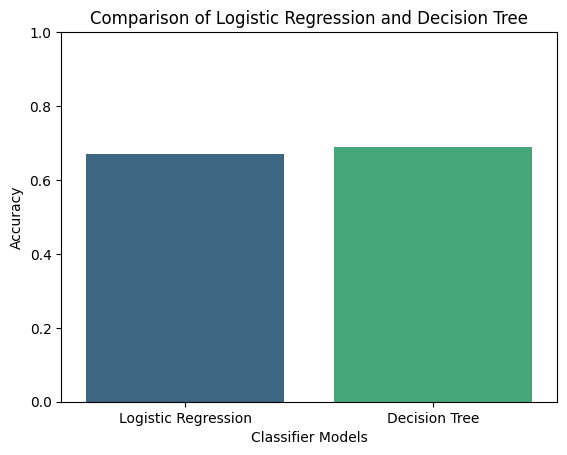

In [71]:
# Compare the accuracy scores of Logistic Regression and Decision Tree models using a bar plot

# accuracy_scores: A list containing the accuracy scores for both models.
# [random_search.best_estimator_.score(Xtest, ytest), random_search_decision_tree.best_estimator_.score(Xtest, ytest)]: 
#   Accuracy scores obtained from the best estimators of Logistic Regression and Decision Tree models on the test set.

accuracy_scores = [random_search_log_regression.best_estimator_.score(Xtest, ytest), random_search_decision_tree.best_estimator_.score(Xtest, ytest)]

# classifiers: A list containing the names of the classifier models.
classifiers = ['Logistic Regression', 'Decision Tree']

# Create a bar plot using Seaborn
# x=classifiers: Specify the x-axis as the classifier names.
# y=accuracy_scores: Specify the y-axis as the corresponding accuracy scores.
# palette='viridis': Use the 'viridis' color palette for better visualization.
sns.barplot(x=classifiers, y=accuracy_scores, palette='viridis')

# Label the x-axis as 'Classifier Models'
plt.xlabel('Classifier Models')

# Label the y-axis as 'Accuracy'
plt.ylabel('Accuracy')

# Set the title of the plot
plt.title('Comparison of Logistic Regression and Decision Tree')

# Assuming accuracy scores are between 0 and 1, set the y-axis limits accordingly
plt.ylim([0, 1])

# Display the plot
plt.show()


### 7. Conclusion

Project Conclusion: Predictive Modeling for Diabetes

In this project, we explored the relationships among various physiological variables and their impact on predicting diabetes. We utilized logistic regression and decision tree models to predict the likelihood of diabetes based on the available features. Here's a summary of the findings:

Logistic Regression:
- **Strengths:**
  - Achieved a precision of 69% for non-diabetic cases and 57% for diabetic cases.
  - Demonstrated high recall (90%) for non-diabetic cases.
  - Overall accuracy reached 68%.

- **Areas for Improvement:**
  - Lower recall (25%) for diabetic cases.
  - F1-score for diabetic cases was relatively low at 0.35.

Decision Tree:
- **Strengths:**
  - Achieved a balanced precision of 78% for non-diabetic cases and 56% for diabetic cases.
  - Showed a balanced recall of 75% for non-diabetic cases and 60% for diabetic cases.
  - Overall accuracy reached 70%.

- **Areas for Improvement:**
  - F1-score for diabetic cases was moderate at 0.58.

Conclusion:
Both models provided valuable insights into the factors influencing diabetes. The logistic regression model excelled in precision for non-diabetic cases but struggled with recall for diabetic cases. On the other hand, the decision tree model achieved a balanced performance in precision and recall for both classes.